# Reprojecting datacube and raster data <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline

import sys
import datacube 
import xarray as xr
import matplotlib.pyplot as plt

from odc.algo import xr_reproject
from datacube.testutils.io import rio_slurp_xarray

sys.path.append('../Scripts')
from dea_plotting import rgb


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Reprojecting_data')

## Loading datacube data to match a raster

### Load a raster file
First we load a GeoTIFF raster from file using `xr.open_rasterio`. 
The example below loads a single band Digital Elevation Model raster for the Canberra region with a spatial resolution of ~0.002075 decimel degrees (approximately equal to 250 m pixels at the equator) in the WGS 84 (`EPSG:4326`) coordinate system.


In [3]:
# Load raster, and remove redundant "band" dimension
raster = xr.open_rasterio("../Supplementary_data/Reprojecting_data/canberra_dem_250m.tif").squeeze("band", drop=True)

We can plot the data to get an idea of what it looks like.
The plot will show Lake Burley Griffin in the centre as an area of low elevation (dark pixels), and nearby areas of higher elevation as brighter pixels (e.g. Mt Ainslie, Black Mountain, Red Hill).

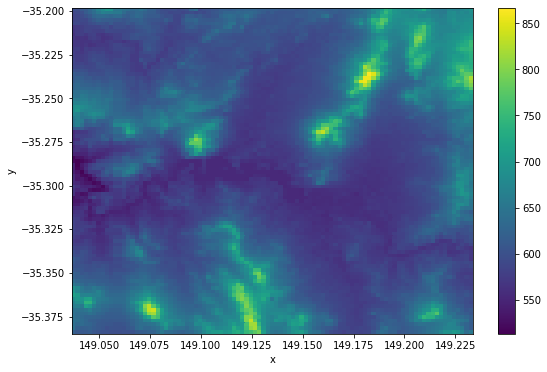

In [4]:
raster.plot(size=6)

### Load datacube data
We can now load data from the datacube to exactly match the projection and resolution of our raster data.
The key here is the `like=raster.geobox`, which will load datacube data to match the spatial grid of our raster.

In [5]:
# Load data from datacube
ds = dc.load(
    product="ga_ls8c_ard_3",
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    time=("2019-01-10", "2019-01-15"),
    like=raster.geobox,
    resampling="nearest",
    group_by="solar_day"
)


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


When we plot the result, it should appear similarly pixelated to the ~250 m resolution raster we loaded above:

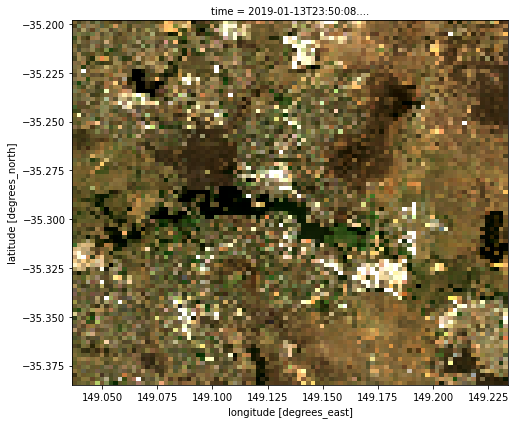

In [6]:
rgb(ds, col='time')

We can also directly compare the geobox of the two datasets to verify they share the same spatial grid:

In [7]:
ds.geobox == raster.geobox

True

Now that our two datasets share the same grid, we can use our raster as a mask, for example to mask out all satellite pixels except those located on hills (e.g. greater than 600 m elevation):

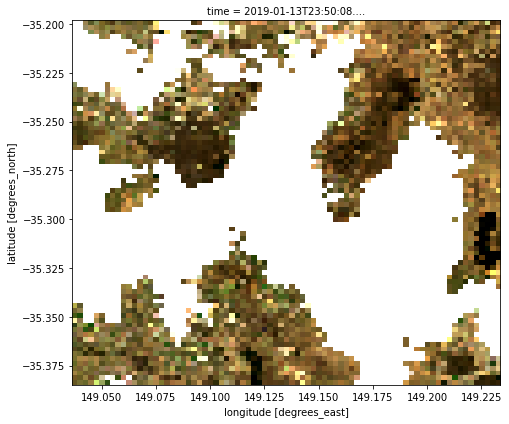

In [8]:
# Rename raster dimensions to match datacube conventions for data
# with geographic coordinates
if raster.geobox.crs.geographic:
    raster = raster.rename({'x': 'longitude', 'y': 'latitude'})

# Identify hilly areas
is_hilly = raster > 600

# # Apply mask to set non-hilly areas to `NaN`
ds_masked = ds.where(is_hilly)

# Plot the masked data
rgb(ds_masked, col='time')

## Reprojecting datacube data to match a raster
The example above demonstrated how to load *new* satellite data from the datacube to match the spatial grid of a raster. 
However, sometimes we may have already loaded satellite data with a projection and resolution that is different from our raster. 
In this case, we need to reproject this existing dataset to match our raster.

For example, we may have loaded Landsat 8 data from the datacube with 30 m pixels in the Australia Albers (`EPSG:3577`) projection system (note that in this example we specify the `x`, `y`, `resolution` and `output_crs` parameters, rather than taking them directly from our raster using `like=raster.geobox` in the previous example).

In [9]:
# Load data from datacube
ds = dc.load(
    product="ga_ls8c_ard_3",
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    time=("2019-01-10", "2019-01-15"),
    x=(149.04, 149.23),
    y=(-35.19, -35.38),
    resolution=(-30, 30),
    output_crs="EPSG:3577",
    group_by="solar_day",
)

# Load raster, and remove redundant "band" dimension
raster = xr.open_rasterio("../Supplementary_data/Reprojecting_data/canberra_dem_250m.tif").squeeze("band", drop=True)

If we plot our satellite data, we can see that it is much higher resolution than our pixelated DEM raster:

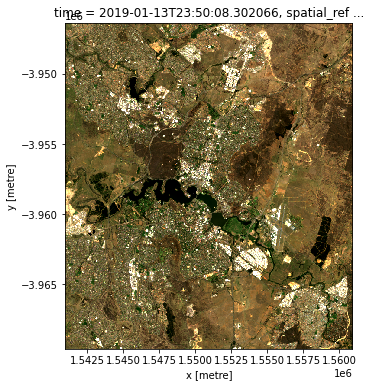

In [10]:
rgb(ds)

### Reproject datacube data

In [11]:
# This fails
ds_reprojected = xr_reproject(src=ds, geobox=raster.geobox)

# # This fails
# if raster.geobox.crs.geographic:
#     raster = raster.rename({'x': 'longitude', 'y': 'latitude'})
#     ds_reprojected = xr_reproject(src=ds, geobox=raster.geobox)
    
# # This works
# if raster.geobox.crs.geographic:
#     ds = ds.rename({'x': 'longitude', 'y': 'latitude'})
#     ds_reprojected = xr_reproject(src=ds, geobox=raster.geobox)


ValueError: coordinate y has dimensions ('y',), but these are not a subset of the DataArray dimensions ('time', 'latitude', 'longitude')

Now if we plot our reprojected data, we can see that our satellite imagery now has a similar resolution to our pixelated raster:

In [ ]:
rgb(ds_reprojected)

Once again, we can also verify that the two datasets have identical spatial grids:

In [ ]:
ds_reprojected.geobox == raster.geobox

## Reprojecting a raster to match datacube data

### Load raster and datacube data

In [ ]:
# Load data from datacube
ds = dc.load(
    product="ga_ls8c_ard_3",
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    time=("2019-01-10", "2019-01-15"),
    x=(149.10, 149.18),
    y=(-35.22, -35.35),
    resolution=(-30, 30),
    output_crs="EPSG:3577",
    group_by="solar_day",
)

# Load raster, and remove redundant "band" dimension
raster = xr.open_rasterio("../Supplementary_data/Reprojecting_data/canberra_dem_250m.tif").squeeze("band", drop=True)

In [ ]:
# Reproject raster to match satellite datacube data
raster_reprojected = xr_reproject(src=raster, geobox=ds.geobox, resampling='average')

In [ ]:
raster_reprojected.plot()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)